# A4: Resume Parser

## 1. Load data

In [1]:
import numpy as np 
import pandas as pd
import spacy

In [2]:
df_resume = pd.read_csv('data/Resume.csv')

In [3]:
df_resume.head(5)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [5]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000,]
df_resume.shape

(1000, 4)

In [6]:
df_resume.Resume_str.values[:10]

array(['         PRODUCTION SUPERVISOR / VALUE STREAM LEADER           Summary    To obtain employment within your company with an  opportunity for growth and advancement.      Highlights          Experienced in production scheduling  Knowledgeable of quality control standards  Experience in value stream mapping  Dedication to product quality              Accomplishments     Planned, directed, coordinated and assigned manpower to efficiently meet production requirements.Supervised first shift operations and more than thirty-five production and assembly line staff.       Experience      Production Supervisor / Value Stream Leader    October 2014       Company Name   －   City  ,   State     Responsible for daily production needs within the basic compressor build lines. Reviewed production orders, schedules, delivery dates and inventory levels to determine product availability. Mastered the intricacies of the process flow within each department. Established and adjusted work procedures to

## 2. Load skill data (need to load others: experiences and certification, contact information)

In [7]:
# from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_md')

In [8]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

### add skill data

In [9]:
entity_path = 'data/entity.jsonl'

In [10]:
# Add an EntityRuler for skills, educationa and certification
ruler = nlp.add_pipe("entity_ruler", before="ner")
ruler.from_disk(entity_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler',
 'ner']

In [11]:
# Load skills from JSONL file
with open(entity_path, "r") as file:
    skills_data = [line.strip() for line in file]

skills = list(set(skills_data))
type(skills)

list

In [12]:
patterns = [
    {"label": "PHONE", "pattern": [{"TEXT": {"REGEX": "((\d){7})"}}]},
    {"label": "EMAIL", "pattern": [{"TEXT": {"REGEX": "\\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\\b"}}]}
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["bsc", "bachelor", "bachelor's", "b.a", "b.s", "b.c.sc"]}}, {"IS_ALPHA": True, "OP": "*"}]},
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["msc", "master", "master's", "m.a", "m.s"]}}, {"IS_ALPHA": True, "OP": "*"}]},
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["phd", "ph.d", "doctor", "doctorate","post-doctoral", "post-doc", "postdoctoral", " "]}}, {"IS_ALPHA": True, "OP": "*"}]},
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["dip", "diploma"]}}, {"IS_ALPHA": True, "OP": "*"}]},
    
]

ruler.add_patterns(patterns)

In [14]:
# Check if "of" is a stop word
is_of_stopword = nlp.vocab["@gmail.com"].is_stop
print(is_of_stopword)

False


## 3. Cleaning Text

clean the dataset in a few steps:
- remove hyperlinks, special characters, or punctuations
- lowering text
- lemmatizing text to its base form for normalization
- removing english stopwords

In [15]:
# remove hyperlinks

import re

def remove_hyperlinks(sentence):
    
    #just in case there is hyperlink....
    sentence = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        sentence
    )
    
    return sentence

In [16]:
# clean the data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    
    # remove hyperlink
    # sentence = remove_hyperlinks(sentence)
    
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and \
            token.pos_ != 'SYM' and token.pos_ != 'SPACE':
            clean_tokens.append(token.lemma_.lower().strip())
    
    return " ".join(clean_tokens)

In [17]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

## 4. Extract Information

### extract skills 
- extract skills, create a column called skills and append the unique skills to our dataset.
this is done for visualization.

In [18]:
# extract skills
def get_skills(text):
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
    
    return skills

# get the unique skills
def unique_skills(x):
    return list(set(x))

In [19]:
df_resume["skills"] = df_resume.Clean_resume.apply(get_skills)
df_resume["skills"] = df_resume.skills.apply(unique_skills)
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,skills
2476,29534737,PRODUCTION SUPERVISOR / VALUE STREAM ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,production supervisor value stream leader summ...,"[air, connect, training, product design, proje..."
1158,23302948,CONSULTANT Profile Resul...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant profile result drive team orient re...,"[project management, co2, 13, reservoir modeli..."
912,37292350,PROGRAM SUPPORT ASSISTANT E...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE,program support assistant experience june 2012...,"[veterinary medicine, learning management syst..."
2308,21867728,SENIOR MARKETING AUTOMATION CONSULTAN...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,senior marketing automation consultant summary...,"[project management, b2b, end user, marketing ..."
1952,10176013,CONSTRUCTION ESTIMATOR Summary ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction estimator summary energetic const...,"[project management, rfi, project, prospect, s..."


In [20]:
# extract skills
def get_edu(text):
    doc = nlp(text)
    
    edu = []
    
    for ent in doc.ents:
        if ent.label_ == 'EDUCATION':
            edu.append(ent.text)
    
    return edu

In [21]:
df_resume["education"] = df_resume.Clean_resume.apply(get_edu)
# df_resume["education"] = df_resume.skills.apply(unique_skills)
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,skills,education
2476,29534737,PRODUCTION SUPERVISOR / VALUE STREAM ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,production supervisor value stream leader summ...,"[air, connect, training, product design, proje...",[master]
1158,23302948,CONSULTANT Profile Resul...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant profile result drive team orient re...,"[project management, co2, 13, reservoir modeli...","[post - doctoral, post - doctoral]"
912,37292350,PROGRAM SUPPORT ASSISTANT E...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE,program support assistant experience june 2012...,"[veterinary medicine, learning management syst...",[]
2308,21867728,SENIOR MARKETING AUTOMATION CONSULTAN...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,senior marketing automation consultant summary...,"[project management, b2b, end user, marketing ...",[bachelor]
1952,10176013,CONSTRUCTION ESTIMATOR Summary ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction estimator summary energetic const...,"[project management, rfi, project, prospect, s...",[bachelor]


In [22]:
# extract certificate
def get_certi(text):
    doc = nlp(text)
    
    certificate = []
    
    for ent in doc.ents:
        if ent.label_ == 'CERTIFICATES':
            certificate.append(ent.text)
    
    return certificate

In [23]:
df_resume["certificate"] = df_resume.Clean_resume.apply(get_certi)
# df_resume["education"] = df_resume.skills.apply(unique_skills)
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,skills,education,certificate
2476,29534737,PRODUCTION SUPERVISOR / VALUE STREAM ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,production supervisor value stream leader summ...,"[air, connect, training, product design, proje...",[master],[]
1158,23302948,CONSULTANT Profile Resul...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant profile result drive team orient re...,"[project management, co2, 13, reservoir modeli...","[post - doctoral, post - doctoral]",[]
912,37292350,PROGRAM SUPPORT ASSISTANT E...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE,program support assistant experience june 2012...,"[veterinary medicine, learning management syst...",[],[]
2308,21867728,SENIOR MARKETING AUTOMATION CONSULTAN...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,senior marketing automation consultant summary...,"[project management, b2b, end user, marketing ...",[bachelor],[]
1952,10176013,CONSTRUCTION ESTIMATOR Summary ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction estimator summary energetic const...,"[project management, rfi, project, prospect, s...",[bachelor],[]


In [24]:
from collections import defaultdict
def get_info(text):
    doc = nlp(text)
    info = defaultdict(list)
    for ent in doc.ents:
        if ent.label_[:5] == "SKILL":
            info["SKILL"].append(ent.text)
        if ent.label_ == "EMAIL":
            info["EMAIL"].append(ent.text)
        if ent.label_ == "CERTIFICATES":
            info['CERTIFICATE'].append(ent.text)
        if ent.label_ == "ORG":
            info['ORG'].append(ent.text)
        else:
            info[ent.label_].append(ent.text)
    return info


## 5. Visualization

In [27]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(53, 8)

In [28]:
all_skills = np.concatenate(df_resume_it.skills.values)

In [29]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))
counting

OrderedDict([('information technology', 48),
             ('management', 45),
             ('system', 45),
             ('technology', 45),
             ('software', 43),
             ('it', 41),
             ('project', 40),
             ('application', 40),
             ('technical', 35),
             ('training', 34)])

<BarContainer object of 10 artists>

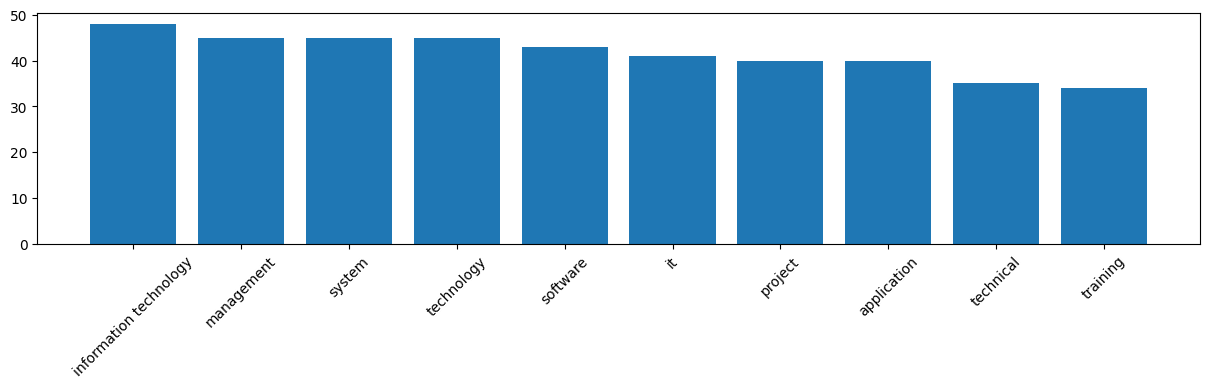

In [30]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15,3))
plt.xticks(rotation = 45)

plt.bar(counting.keys(),counting.values())

## 6. Name Entity Recognition

In [31]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]
text2 = "Kyi Thin Nu at AIT 09259469046 +959955649044 Bachelor of Engineering at UTYCC and Master of Engineering at AIT kyi@ait.asia kyi@gmail.com erp Consultant Enterprise Resource Planning IT support User Training Accounting reporting"

text = preprocessing(text2)
doc  = nlp(text)

colors  = {"SKILL": "linear-gradien(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc, style = 'ent', options=options)

## 7. load the PDF

In [32]:
from PyPDF2 import PdfReader
from spacy import displacy

In [33]:
reader = PdfReader("data/resume_dataset/accountant/10554236.pdf")
page   = reader.pages[0]
text   = page.extract_text()

In [34]:
text = preprocessing(text)
doc = nlp(text)

colors  = {"SKILL": "linear-gradien(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc, style = 'ent', options=options)

In [42]:
raw_text = "Kyi Thin Nu kyi@gmail.com kyithinnu@ait.asia 09955649044 AIT Thailand Bachelor Master certificate of leadership Asian Institute of Technology UTYCC"

In [43]:
clean_text = preprocessing(raw_text)
doc = nlp(text)
clean_text

'kyi thin nu kyi@gmail.com kyithinnu@ait.asia 09955649044 ait thailand bachelor master certificate leadership asian institute technology utycc'

In [52]:
info_test = get_info(clean_text)

for k,v in info_test.items():
    print(f"{k}\t{v}")

SKILL	['thin', 'thin', 'leadership', 'leadership', 'technology', 'technology']
EMAIL	['kyi@gmail.com', 'kyi@gmail.com', 'kyithinnu@ait.asia', 'kyithinnu@ait.asia']
PHONE	['09955649044']
GPE	['thailand']
EDUCATION	['bachelor', 'master']
ORG	['asian institute']


In [49]:
# func to read pdf and proceed resume parser
from PyPDF2 import PdfReader

def readPDF(path):
    reader = PdfReader(path)
    
    page = reader.pages[0]
    text = page.extract_text()
    text = preprocessing(text)
    doc = nlp(text)

    # person    = []
    email     = []
    phone     = []
    skill     = []
    education = []
    organization = []

    for ent in doc.ents:
        if ent.label_ == 'PHONE':
            phone.append(ent.text)
        if ent.label_ == 'EMAIL':
            email.append(ent.text)
        if ent.label_ == 'SKILL':
            skill.append(ent.text)
        if ent.label_ == 'EDUCATION':
            education.append(ent.text)
        if ent.label_ == 'ORG':
            organization.append(ent.text)
    
    phone     = set(phone)  
    email     = set(email)     
    skill     = set(skill)
    education = set(education)
    organization = set(organization)
    
    info = {'phone': phone, 'email': email, 'skills':skill,'education':education, 'organization': organization}
    df = pd.DataFrame.from_dict(info, orient='index') # for dataframe
    
    return info, df